# Classification-ResNet

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

ResNet Model的百度盘地址

链接: https://pan.baidu.com/s/1skJ0Q1v 密码: dfjb

希望大家不要转贴该地址，避免被关闭后大家的麻烦。

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/ResNet/ResNet-50-model.caffemodel'):
    print 'ResNet-Net found.'
else:
    print 'You must download pre-trained ResNet model...'

ResNet-Net found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [4]:
caffe.set_mode_cpu()

#model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
#model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

model_def = caffe_root + 'models/ResNet/resnet-protofiles/ResNet_50_deploy.prototxt'
model_weights = caffe_root + 'models/ResNet/ResNet-50-model.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [5]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

(3, 224, 224)

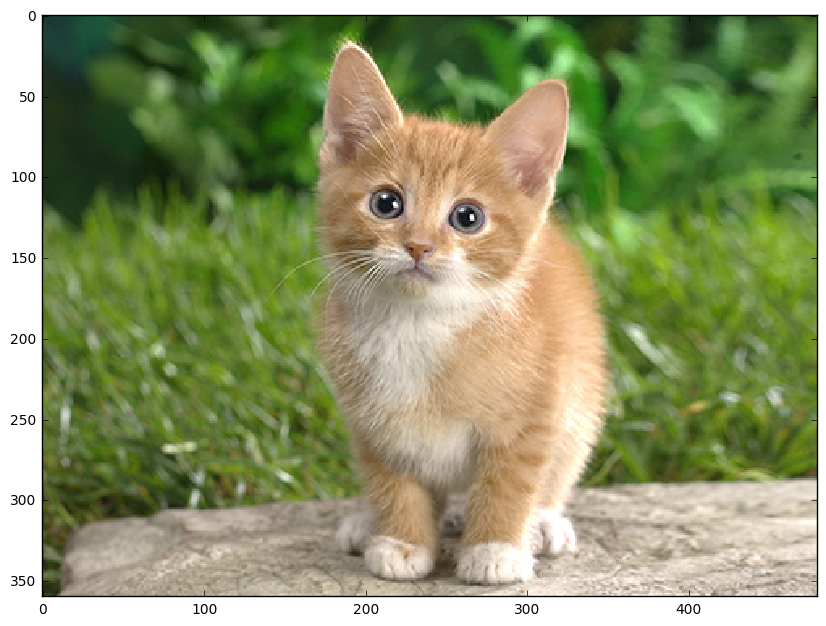

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
transformed_image.shape

* Adorable! Let's classify it!

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 263


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [9]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02113023 Pembroke, Pembroke Welsh corgi


* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.19301684, 'n02113023 Pembroke, Pembroke Welsh corgi'),
 (0.18334676, 'n02124075 Egyptian cat'),
 (0.1811409, 'n02119022 red fox, Vulpes vulpes'),
 (0.1253669, 'n02119789 kit fox, Vulpes macrotis'),
 (0.10238054, 'n02123159 tiger cat')]

* We see that less confident predictions are sensible.

### 4. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [11]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 224, 224)
conv1	(50, 64, 112, 112)
pool1	(50, 64, 56, 56)
pool1_pool1_0_split_0	(50, 64, 56, 56)
pool1_pool1_0_split_1	(50, 64, 56, 56)
res2a_branch1	(50, 256, 56, 56)
res2a_branch2a	(50, 64, 56, 56)
res2a_branch2b	(50, 64, 56, 56)
res2a_branch2c	(50, 256, 56, 56)
res2a	(50, 256, 56, 56)
res2a_res2a_relu_0_split_0	(50, 256, 56, 56)
res2a_res2a_relu_0_split_1	(50, 256, 56, 56)
res2b_branch2a	(50, 64, 56, 56)
res2b_branch2b	(50, 64, 56, 56)
res2b_branch2c	(50, 256, 56, 56)
res2b	(50, 256, 56, 56)
res2b_res2b_relu_0_split_0	(50, 256, 56, 56)
res2b_res2b_relu_0_split_1	(50, 256, 56, 56)
res2c_branch2a	(50, 64, 56, 56)
res2c_branch2b	(50, 64, 56, 56)
res2c_branch2c	(50, 256, 56, 56)
res2c	(50, 256, 56, 56)
res2c_res2c_relu_0_split_0	(50, 256, 56, 56)
res2c_res2c_relu_0_split_1	(50, 256, 56, 56)
res3a_branch1	(50, 512, 28, 28)
res3a_branch2a	(50, 128, 28, 28)
res3a_branch2b	(50, 128, 28, 28)
res3a_branch2c	(50, 512, 28, 28)
res3a	(50, 512, 28, 28)
res3a_res3a_relu_0_split_0	(50,

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [13]:
for layer_name, param in net.params.iteritems():
    print param
    print layer_name + '\t' + str([str(x.data.shape) for x in param])

conv1	['(64, 3, 7, 7)', '(64,)']
bn_conv1	['(64,)', '(64,)', '(1,)']
scale_conv1	['(64,)', '(64,)']
res2a_branch1	['(256, 64, 1, 1)']
bn2a_branch1	['(256,)', '(256,)', '(1,)']
scale2a_branch1	['(256,)', '(256,)']
res2a_branch2a	['(64, 64, 1, 1)']
bn2a_branch2a	['(64,)', '(64,)', '(1,)']
scale2a_branch2a	['(64,)', '(64,)']
res2a_branch2b	['(64, 64, 3, 3)']
bn2a_branch2b	['(64,)', '(64,)', '(1,)']
scale2a_branch2b	['(64,)', '(64,)']
res2a_branch2c	['(256, 64, 1, 1)']
bn2a_branch2c	['(256,)', '(256,)', '(1,)']
scale2a_branch2c	['(256,)', '(256,)']
res2b_branch2a	['(64, 256, 1, 1)']
bn2b_branch2a	['(64,)', '(64,)', '(1,)']
scale2b_branch2a	['(64,)', '(64,)']
res2b_branch2b	['(64, 64, 3, 3)']
bn2b_branch2b	['(64,)', '(64,)', '(1,)']
scale2b_branch2b	['(64,)', '(64,)']
res2b_branch2c	['(256, 64, 1, 1)']
bn2b_branch2c	['(256,)', '(256,)', '(1,)']
scale2b_branch2c	['(256,)', '(256,)']
res2c_branch2a	['(64, 256, 1, 1)']
bn2c_branch2a	['(64,)', '(64,)', '(1,)']
scale2c_branch2a	['(64,)', '(64,)'

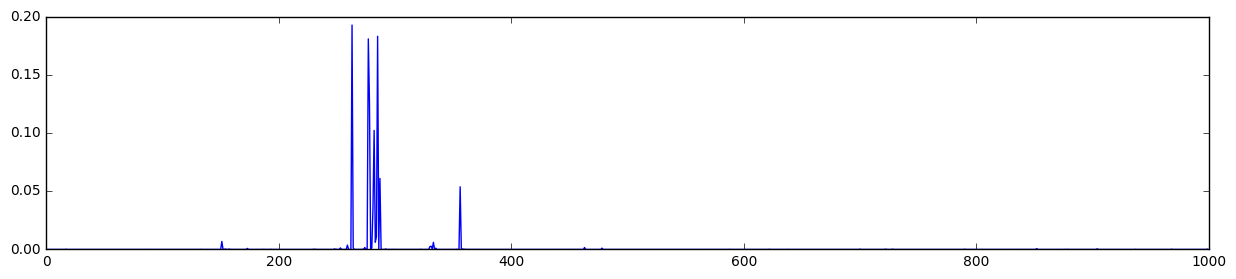

In [14]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)